In [1]:
# For image manipulation
from PIL import Image

# For numerical operations
import numpy as np

# For neural network models and operations
import torch
import torch.nn as nn

# For plotting
import matplotlib.pyplot as plt

In [2]:
from typing import List

def save_gif_PIL(outfile: str, files: List[str], fps: int = 5, loop: int = 0) -> None:
    """Helper function to save a list of image files as a GIF.
    
    Parameters:
        outfile (str): The output GIF file name.
        files (List[str]): List of image file names to be included in the GIF.
        fps (int, optional): Frames per second. Defaults to 5.
        loop (int, optional): Number of loops. Defaults to 0.
    """
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def oscillator(d: float, w0: float, x: torch.Tensor) -> torch.Tensor:
    """Analytical solution to the 1D underdamped harmonic oscillator problem.
    
    Parameters:
        d (float): Damping coefficient.
        w0 (float): Natural frequency.
        x (torch.Tensor): Input tensor containing points where the function is evaluated.
        
    Returns:
        torch.Tensor: Output tensor containing the function values at points in x.
    """
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos_term = torch.cos(phi + w * x)
    exp_term = torch.exp(-d * x)
    y = exp_term * 2 * A * cos_term
    return y

class FCN(nn.Module):
    """Fully Connected Network (FCN) class.
    
    Attributes:
        N_INPUT (int): Number of input features.
        N_OUTPUT (int): Number of output features.
        N_HIDDEN (int): Number of hidden units in each layer.
        N_LAYERS (int): Number of hidden layers.
    """
    
    def __init__(self, N_INPUT: int, N_OUTPUT: int, N_HIDDEN: int, N_LAYERS: int):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )
        self.fch = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()
              ) for _ in range(N_LAYERS - 1)]
        )
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

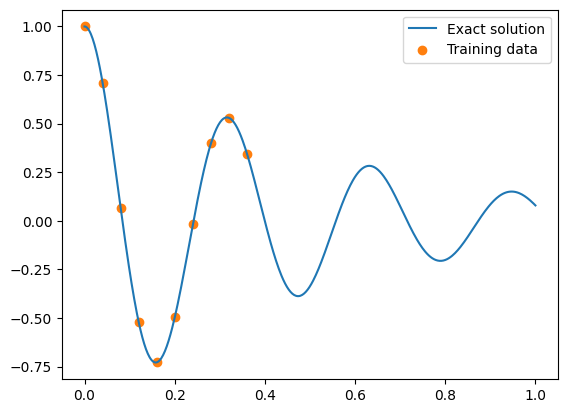

In [3]:
from typing import Tuple

# Constants for harmonic oscillator
DAMPING_COEFFICIENT = 2  # Damping coefficient (d)
NATURAL_FREQUENCY = 20  # Natural frequency (w0)

def compute_analytical_solution(d: float, w0: float, num_points: int = 500) -> Tuple[torch.Tensor, torch.Tensor]:
    """Compute the analytical solution of the harmonic oscillator.
    
    Parameters:
        d (float): Damping coefficient.
        w0 (float): Natural frequency.
        num_points (int): Number of points for the analytical solution.
        
    Returns:
        Tuple[torch.Tensor, torch.Tensor]: x and y coordinates of the analytical solution.
    """
    x = torch.linspace(0, 1, num_points).view(-1, 1)
    y = oscillator(d, w0, x).view(-1, 1)
    return x, y

def plot_analytical_and_training_data(x: torch.Tensor, y: torch.Tensor, x_data: torch.Tensor, y_data: torch.Tensor):
    """Plot the analytical solution and the training data.
    
    Parameters:
        x (torch.Tensor): x coordinates of the analytical solution.
        y (torch.Tensor): y coordinates of the analytical solution.
        x_data (torch.Tensor): x coordinates of the training data.
        y_data (torch.Tensor): y coordinates of the training data.
    """
    plt.figure()
    plt.plot(x, y, label="Exact solution")
    plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
    plt.legend()
    plt.show()

# Compute the analytical solution
x_analytical, y_analytical = compute_analytical_solution(DAMPING_COEFFICIENT, NATURAL_FREQUENCY)

# Slice out training data from the analytical solution
x_training_data = x_analytical[0:200:20]
y_training_data = y_analytical[0:200:20]

# Plot the analytical solution and training data
plot_analytical_and_training_data(x_analytical, y_analytical, x_training_data, y_training_data)

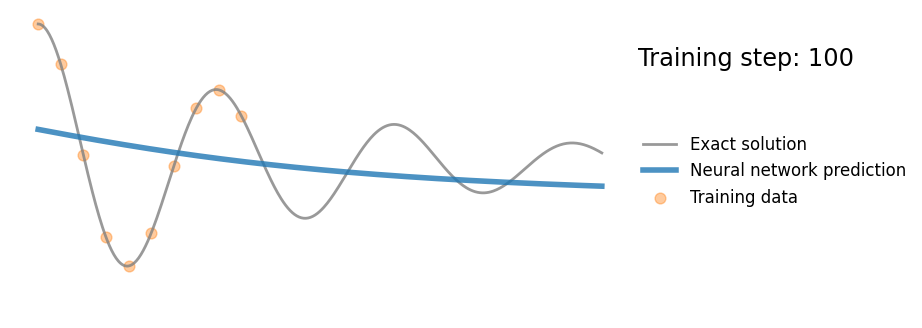

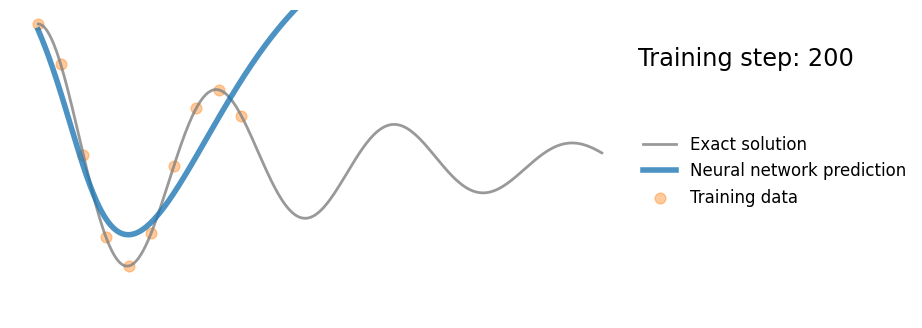

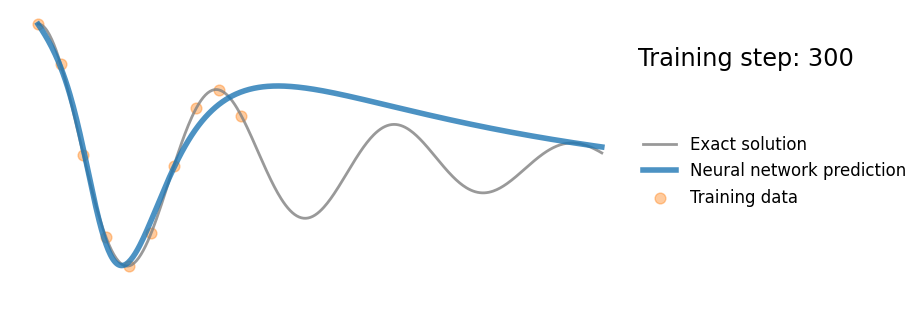

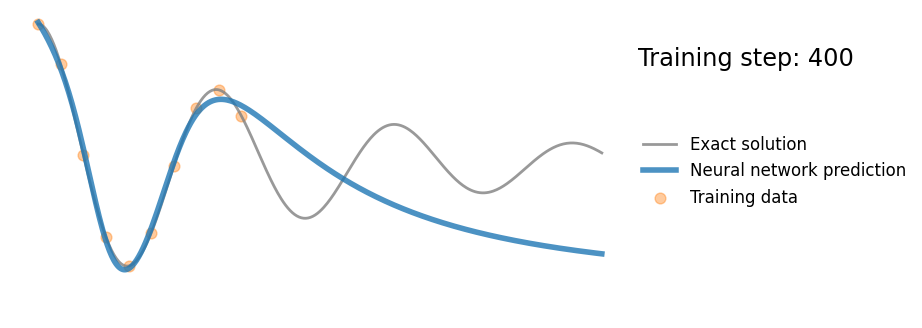

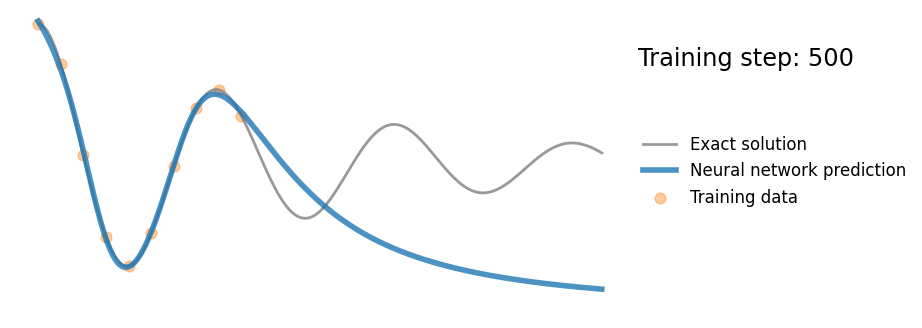

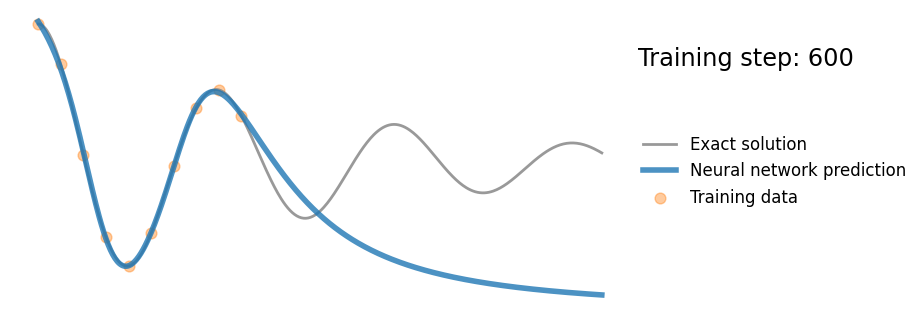

In [4]:
from typing import List

# Hyperparameters
LEARNING_RATE = 1e-3
EPOCHS = 600

def plot_result(x: torch.Tensor, y: torch.Tensor, x_data: torch.Tensor, y_data: torch.Tensor, y_pred: torch.Tensor, 
                xp: torch.Tensor = None, step: int = 0):
    """Plot the training results.
    
    Parameters:
        x, y: Exact solution coordinates.
        x_data, y_data: Training data coordinates.
        y_pred: Neural network prediction.
        xp: Physics loss training locations.
        step: Current training step.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x, y_pred, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    plt.text(1.065, 0.7, f"Training step: {step}", fontsize="xx-large", color="k")
    if xp is not None:
        plt.scatter(xp, -0 * torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, label='Physics loss training locations')
    plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.axis("off")

def train_standard_nn(model: nn.Module, x_data: torch.Tensor, y_data: torch.Tensor, epochs: int, lr: float) -> List[str]:
    """Train a standard neural network.
    
    Parameters:
        model: The neural network model.
        x_data, y_data: Training data.
        epochs: Number of training epochs.
        lr: Learning rate.
        
    Returns:
        List of saved plot filenames.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    files = []
    for i in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x_data)
        loss = torch.mean((y_pred - y_data)**2)
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 10 == 0:
            y_pred = model(x_analytical).detach()
            plot_result(x_analytical, y_analytical, x_training_data, y_training_data, y_pred, step=i + 1)
            file = f"plots/nn_{i + 1:08}.png"
            plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
            files.append(file)
            
            if (i + 1) % 100 == 0:
                plt.show()
            else:
                plt.close("all")
    return files

# Train the standard neural network
torch.manual_seed(123)
model = FCN(1, 1, 32, 3)
saved_files = train_standard_nn(model, x_training_data, y_training_data, EPOCHS, LEARNING_RATE)

# Create a GIF from the saved plots
save_gif_PIL("nn.gif", saved_files, fps=20, loop=0)

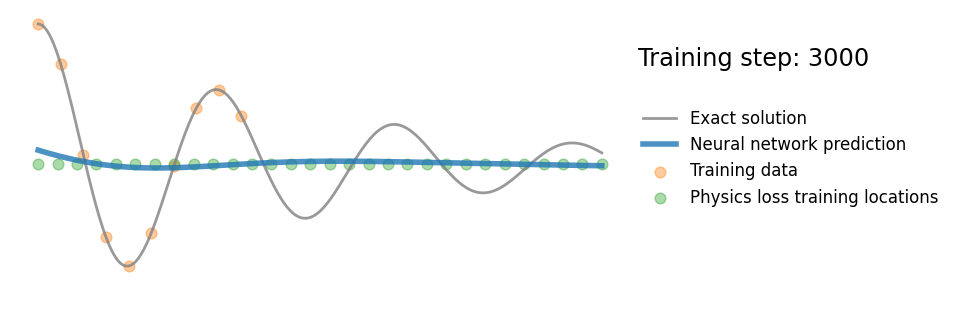

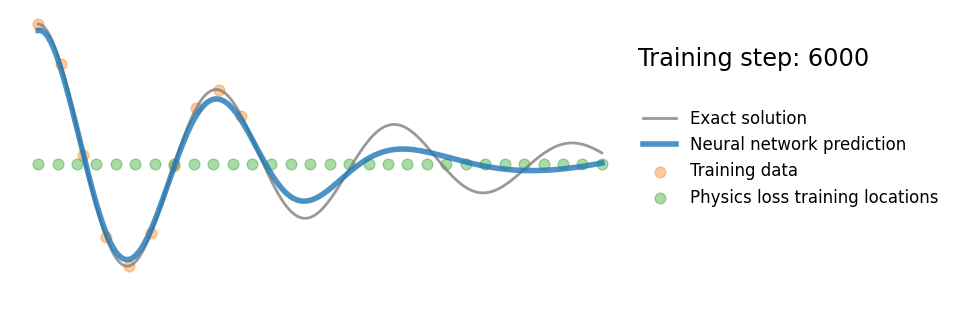

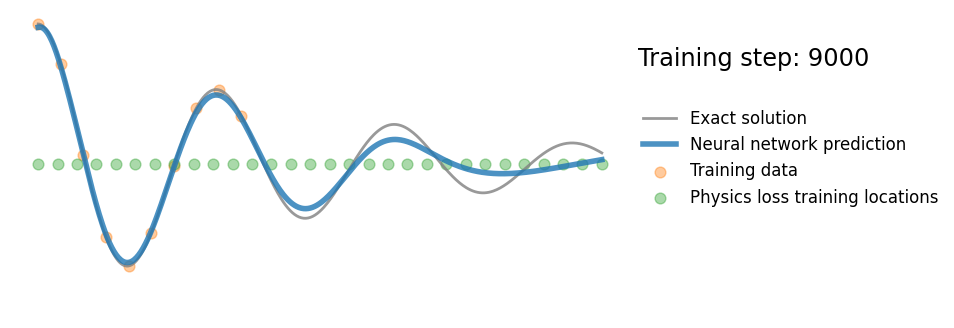

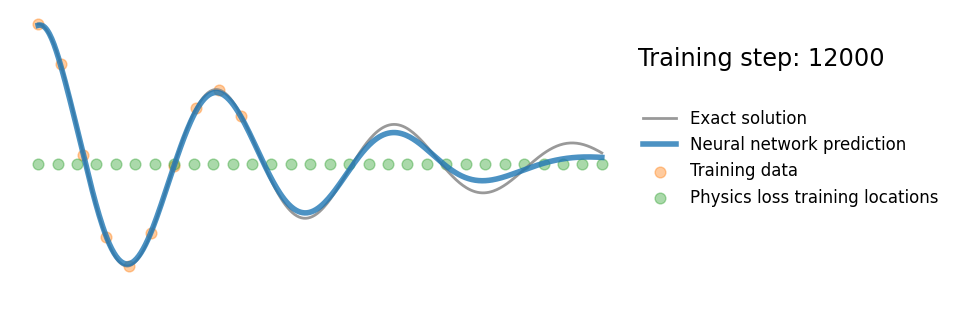

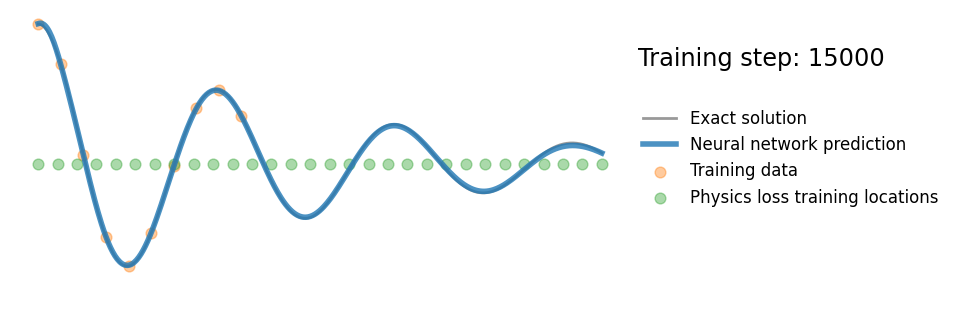

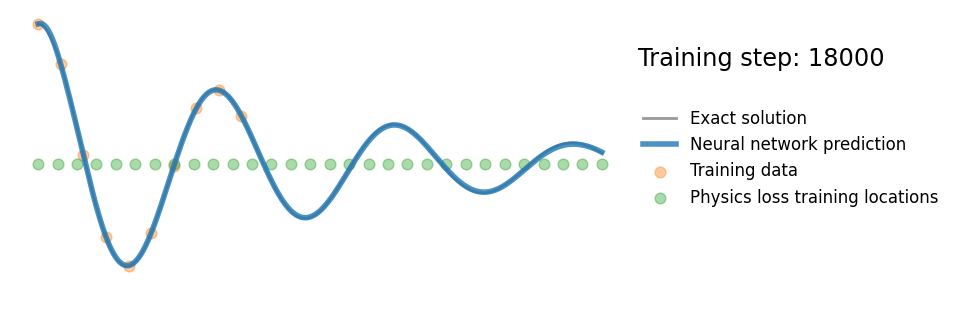

In [5]:
from typing import List

# Hyperparameters and Constants
PHYSICS_LEARNING_RATE = 1e-4
PHYSICS_EPOCHS = 20000
MU, K = 2 * DAMPING_COEFFICIENT, NATURAL_FREQUENCY ** 2

def compute_physics_loss(model: nn.Module, x_physics: torch.Tensor, mu: float, k: float) -> torch.Tensor:
    """Compute the physics-informed loss."""
    y_physics = model(x_physics)
    dx  = torch.autograd.grad(y_physics, x_physics, torch.ones_like(y_physics), create_graph=True)[0]
    dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0]
    physics_residual = dx2 + mu * dx + k * y_physics
    return (1e-4) * torch.mean(physics_residual ** 2)

def train_physics_informed_nn(model: nn.Module, x_data: torch.Tensor, y_data: torch.Tensor, x_physics: torch.Tensor,
                              epochs: int, lr: float, mu: float, k: float) -> List[str]:
    """Train a physics-informed neural network."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    files = []
    for i in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x_data)
        data_loss = torch.mean((y_pred - y_data)**2)
        physics_loss = compute_physics_loss(model, x_physics, mu, k)
        joint_loss = data_loss + physics_loss
        joint_loss.backward()
        optimizer.step()
        
        if (i + 1) % 150 == 0:
            y_pred = model(x_analytical).detach()
            plot_result(x_analytical, y_analytical, x_training_data, y_training_data, y_pred, x_physics.detach(), step=i+1)
            file = f"plots/pinn_{i+1:08}.png"
            plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
            files.append(file)
            
            if (i + 1) % 2000 == 0:
                plt.show()
            else:
                plt.close("all")
    return files

# Generate physics-informed locations
x_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

# Train the physics-informed neural network
torch.manual_seed(123)
model_pinn = FCN(1, 1, 32, 3)
saved_files_pinn = train_physics_informed_nn(model_pinn, x_training_data, y_training_data, x_physics, PHYSICS_EPOCHS, PHYSICS_LEARNING_RATE, MU, K)

# Create a GIF from the saved plots
save_gif_PIL("pinn.gif", saved_files_pinn, fps=20, loop=0)